# Project Report: PLAIcraft

### Section 004, Group 42
Audrey Wang \
Angelina Hang \
Jiangche Xiong \
Brian Law

In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
library(patchwork)

options(repr.plot.height = 10, repr.plot.width = 10)

A [research group](https://plai.cs.ubc.ca/) at UBC collected data about how people play video games by setting up a [MineCraft server](https://plaicraft.ai/) to record players' actions. The group is looking for ways to target their recruitment efforts to make sure the players can generate the most amount of data.

Data regarding all the players' information was collected as players signed in to play the game. 

## 1) `Players` Dataset Description:

In [10]:
players <- read_csv("https://raw.githubusercontent.com/audreyw28/DSCI100-2025W1-004-42/refs/heads/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [11]:
#CALCULATING SUMMARY STATISTICS: RANGE, MEAN, STANDARD DEVIATION

players_range <- players|>
    reframe(played_hours_range = range(played_hours), 
              age_range = range(Age, na.rm = TRUE))
players_range

players_stats <- players|>
    summarize(played_hours_mean = round(mean(played_hours), 2),
              played_hours_sd = round(sd(played_hours), 2),
              age_mean = round(mean(Age, na.rm = TRUE), 2), 
              age_sd = round(sd(Age, na.rm = TRUE), 2))
players_stats

# sum(is.na(players))

played_hours_range,age_range
<dbl>,<dbl>
0.0,9
223.1,58


played_hours_mean,played_hours_sd,age_mean,age_sd
<dbl>,<dbl>,<dbl>,<dbl>
5.85,28.36,21.14,7.39


In [13]:
# INFORMATION ON CATEGORICAL AND LOGICAL DATA:

# count of each unique experience data
players_experience <- players |>
    group_by(experience) |>
    summarize(count = n())
players_experience

# count of each unique subscribe data
players_subscribe <- players |>
    group_by(subscribe) |>
    summarize(count = n())
players_subscribe

# count of each unique gender data
players_gender <- players |>
    group_by(gender) |>
    summarize(count = n())
players_gender

experience,count
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


gender,count
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


In the `players` dataset, there are:
- 196 observations, each of one player
- 7 variables:

| Variable | Type | Description |
|:---|:---|:---|
| `experience` | character | experience level of player |
| `subscribe` | logical | whether the player has subscribed to the game's newsletter or not |
| `hashedEmail` | character | hashed email of player |
| `played_hours` | double | number of hours played (hours)|
| `name` | character | name of player |
| `gender` | character | gender of player |
| `Age` | double | age of player (years) |

Explanations:

`experience` contains:
- 5 unique character entries 

| Data | Count |
|----|----|
| Beginner | 35 |
| Amateur | 63 |
| Regular | 36 |
| Veteran | 48 |
| Pro | 14 |

`subscribe` contains:
- logical values 

| Data | Count |
|----|----|
| TRUE | 144 |
| FALSE | 52 |

`played_hours` has: 

| minimum | mean | maximum | standard deviation |
|----|----|----|----|
| 0.00 | 5.85 | 223.10 | 28.36 |
 - All values are reported in terms of hours

`gender` contains:
- 7 unique character entries

| Data | Count |
|----|----|
| Female | 37 |
| Male | 124 |
| Non-binary | 15 |
| Agender | 2 |
| Two-Spirited | 6 |
| Other | 1 |
| Prefer not to say | 11 |

`Age` has:

| minimum | mean | maximum | standard deviation |
|----|----|----|----|
| 9.00 | 21.14 | 58.00 | 7.39 |
 - All values are reported in terms of years

`hashedEmail` and `name` are identifying information for each player. For our project, these variables are not relevant, therefore, will not be explored.


Some issues exist in this dataset in that: 
- 2 player ages were missing (NA) $ \rightarrow $ decreased accuracy when performing summary statistics for `Age`
- the experience levels were self-declared by players $ \rightarrow $ could be biased when players over/under estimate their ability

## 2) Investigated Question:

For the report, we want to explore which player characteristics are most predictive of subscribing to a game-related newsletter.
-  If someone is subscribed, that means they are more engaged with the game.
-  `name`, `hashedEmail`, and `gender` are unlikely to be informative in predicting `subscribe`.
-  `experience` is self-declared and therefore unreliable.
-  `Age` may be predictive if the game appeals to players of certain ages $ \rightarrow $ players are more likely to subscribe.
-  `played_hours` may be predictive since higher `played_hours` means the player has a higher affinity for the game $ \rightarrow $ players are more likely to subscribe.

Therefore, our specific question is:
- Can `Age` and `played_hours` predict `subscribe` in the `players` dataset?

The `players` dataset will make this K-nearest-neighbors classification problem possible by providing a sufficient number of observations (194) of players and their respective `played_hours`, `Age`and `subscribe`. 

## 3) Exploratory Data Analysis

The dataset is tidy; variables of interest (`played_hours`, `Age` and `subscribe`) are in separate columns, and each observation is one player. 

To cater the data to answering our specific question, we will: 
- select for the interested variables
- drop NAs
- convert any non-numeric (logical) variables to factor variables since they will be used as categorical variables
- recode the `subscribe` variable into "Yes" and "No" to increase the readability of our analysis

In [14]:
players <- players |>
    select(subscribe, Age, played_hours)|>
    drop_na()|>
    mutate(subscribe = as_factor(subscribe),
           subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
head(players)

subscribe,Age,played_hours
<fct>,<dbl>,<dbl>
Yes,9,30.3
Yes,17,3.8
No,17,0.0
Yes,21,0.7
Yes,21,0.1
Yes,17,0.0


In [15]:
# CALCULATING NUMBER AND PERCENTAGE OF SUBSCRIBED AND NOT SUBSCRIBED OBSERVATIONS
num_obs <- nrow(players)
players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)

subscribe,count,percentage
<fct>,<int>,<dbl>
No,52,26.80412
Yes,142,73.19588


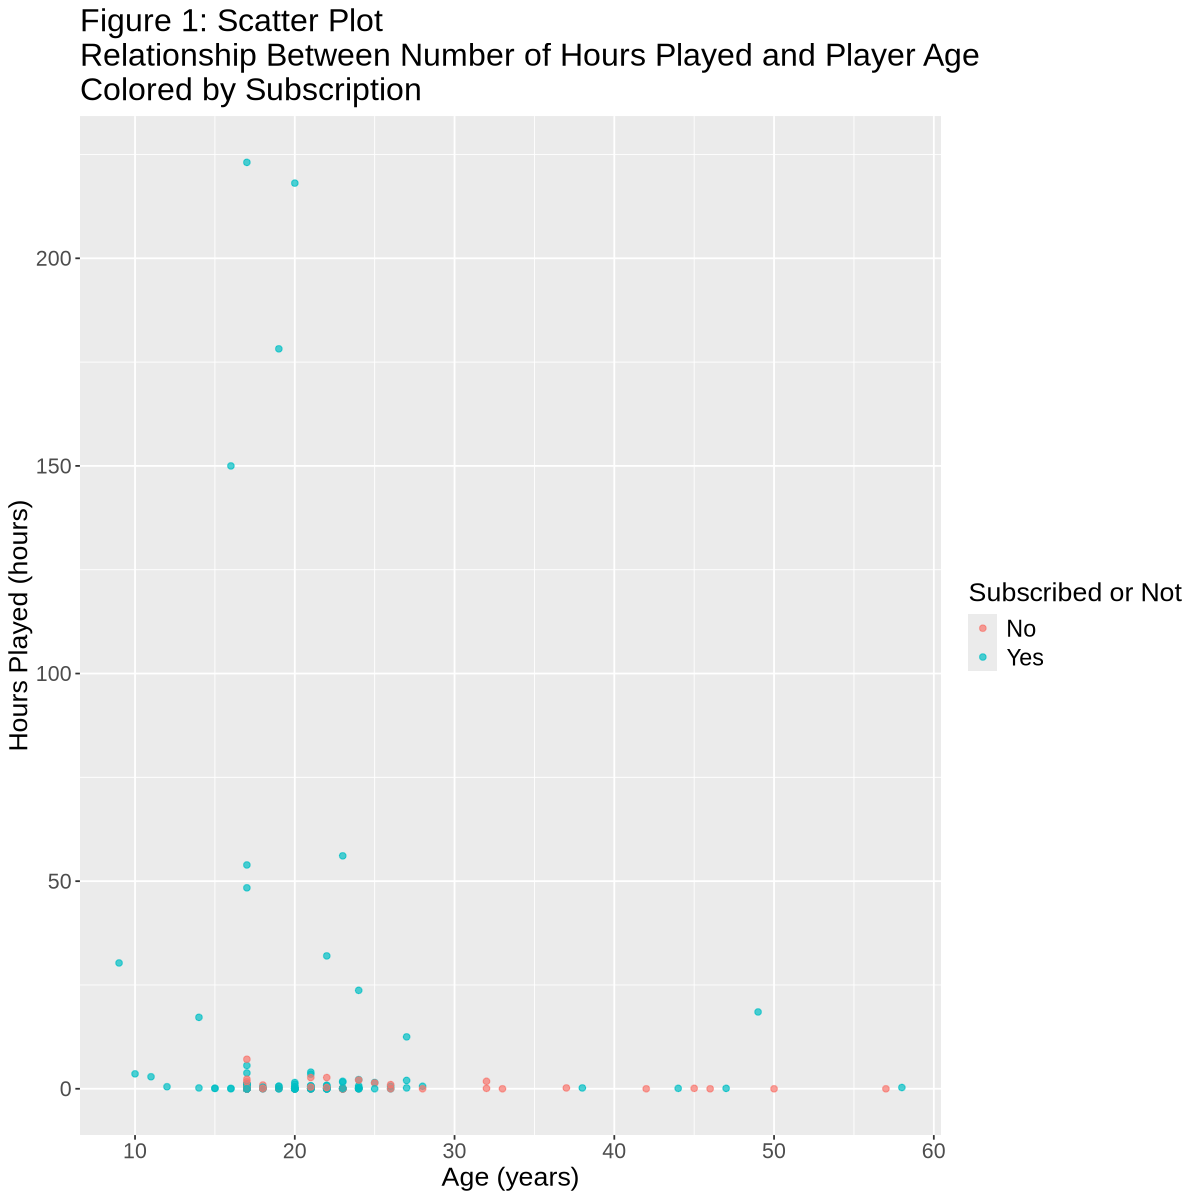

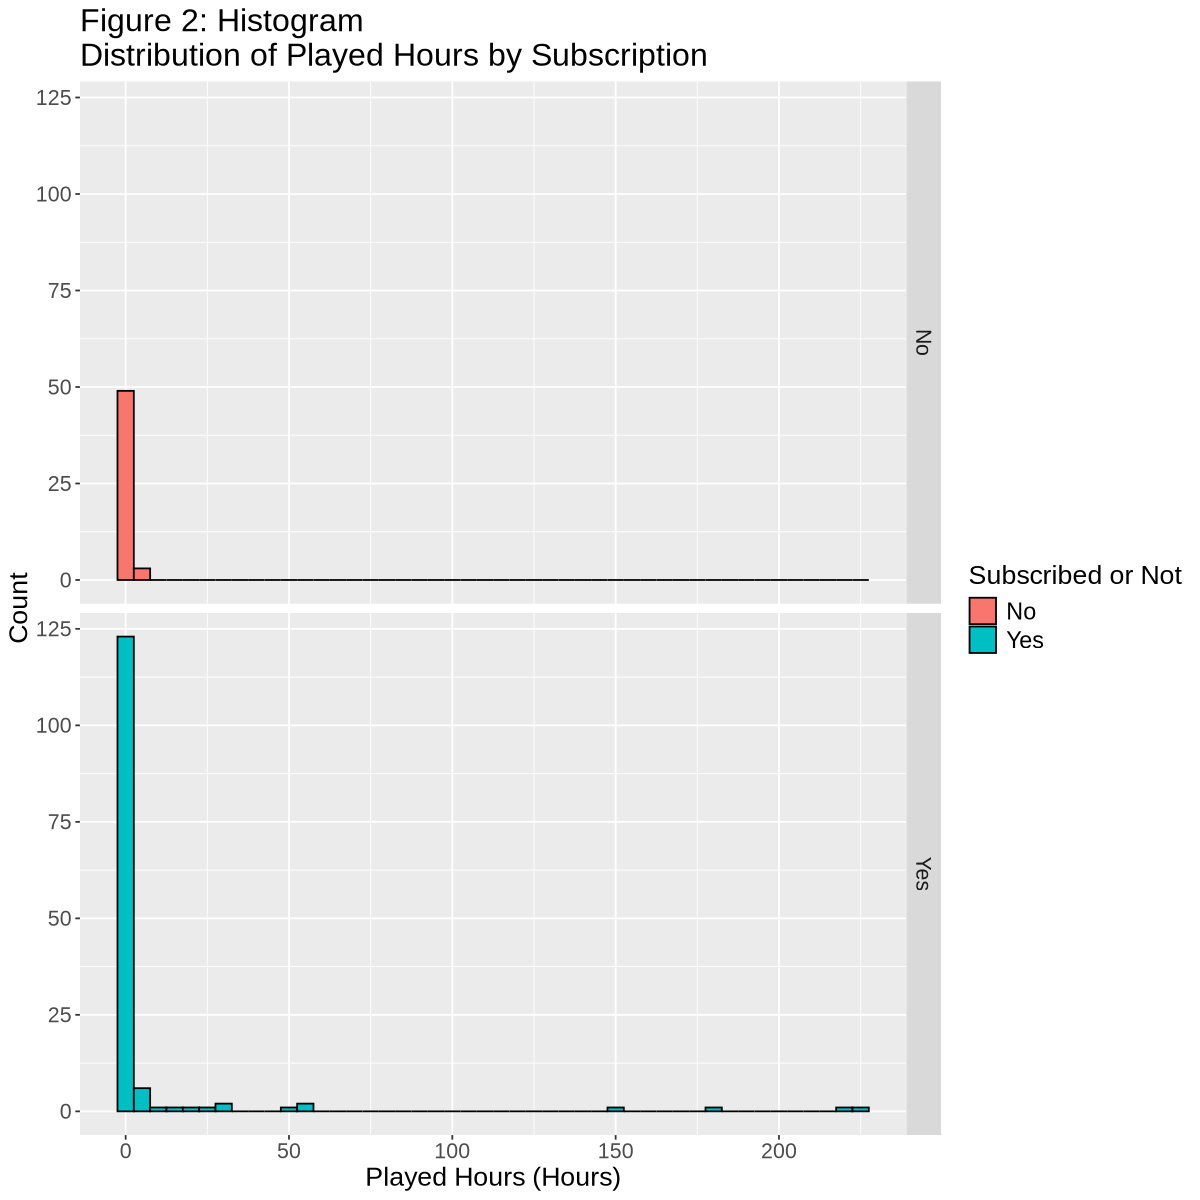

In [16]:
figure_1 <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.7) +
    labs(x = "Age (years)", 
         y = "Hours Played (hours)", 
         title = "Figure 1: Scatter Plot\nRelationship Between Number of Hours Played and Player Age\nColored by Subscription",
         color = "Subscribed or Not") +
    theme(text = element_text(size = 16), 
         legend.text = element_text(size = 14),
         legend.title = element_text(size = 16))
figure_1

figure_2 <- ggplot(players, aes(x = played_hours, fill = subscribe))+
    geom_histogram(position = "identity", binwidth = 5, color = "black") + 
    labs(x = "Played Hours (Hours)", 
         y = "Count", 
         title = "Figure 2: Histogram\nDistribution of Played Hours by Subscription",
         fill = "Subscribed or Not") +
    facet_grid(rows = vars(subscribe)) +
    theme(text = element_text(size = 16), 
         legend.text = element_text(size = 14),
         legend.title = element_text(size = 16))
figure_2


The response variable (`subscribe`) is ~27% No and ~73% Yes in the `players` dataset. Therefore, since it is only mildly imbalanced, we do not have to worry about data imbalance when performing K-nearest-neighbors classification at this stage. 

Through **Figure 1**, we see that higher `played_hours` is associated with players more likely to be subscribed, and that `Age` values above ~17 years is associated with players being more likely to be unsubscribed. This suggests that `played_hours` and `Age` may be useful predictors of subscription. 

**Figure 2** further reinforces that players with high `played_hours` are likely to be subscribed. Therefore, `played_hours` can be used as a predictor variable.

## 4) Methods and Results

Some steps in creating our **KNN classification** model: 
1. Set seeds when splitting data and running each cross validation to ensure reproducibility. 
2. Split data into 70% training and 30% (most commonly used proportion in our current experience of predictive analysis)
3. `Age` and `played_hours` will be scaled to have a mean of 0 and standard deviation of 1.
5. Perform 5-fold cross validation (most commonly used in this course and is simpler) on 1-30 neighbors (K range ~1/5 of the training data observations) to tune the model.
6. Select neighbors with the highest cross-validated accuracy for our final model.
7. Evaluate for model accuracy on test data. 

### We will first tune for the optimal K value on the training set. 

In [17]:
set.seed(1000)

# split data into training and testing set
players_split <- initial_split(players, prop = 0.70, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

In [18]:
# create recipe
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#number of neighbors to cross validate on (UPPER LIMIT FOR NEIGHBORS = 1/5th of training set size)
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

# model specification for tuning
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# number of folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [20]:
set.seed(100)

# fit model and collect metrics dataframe
knn_results_tune <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals) |>
       collect_metrics() |>
       filter(.metric == "accuracy")

# find k with highest accuracy
best_k <- knn_results_tune |>
        arrange(desc(mean)) |>
        head(1)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,accuracy,binary,0.762556,5,0.01114903,Preprocessor1_Model17


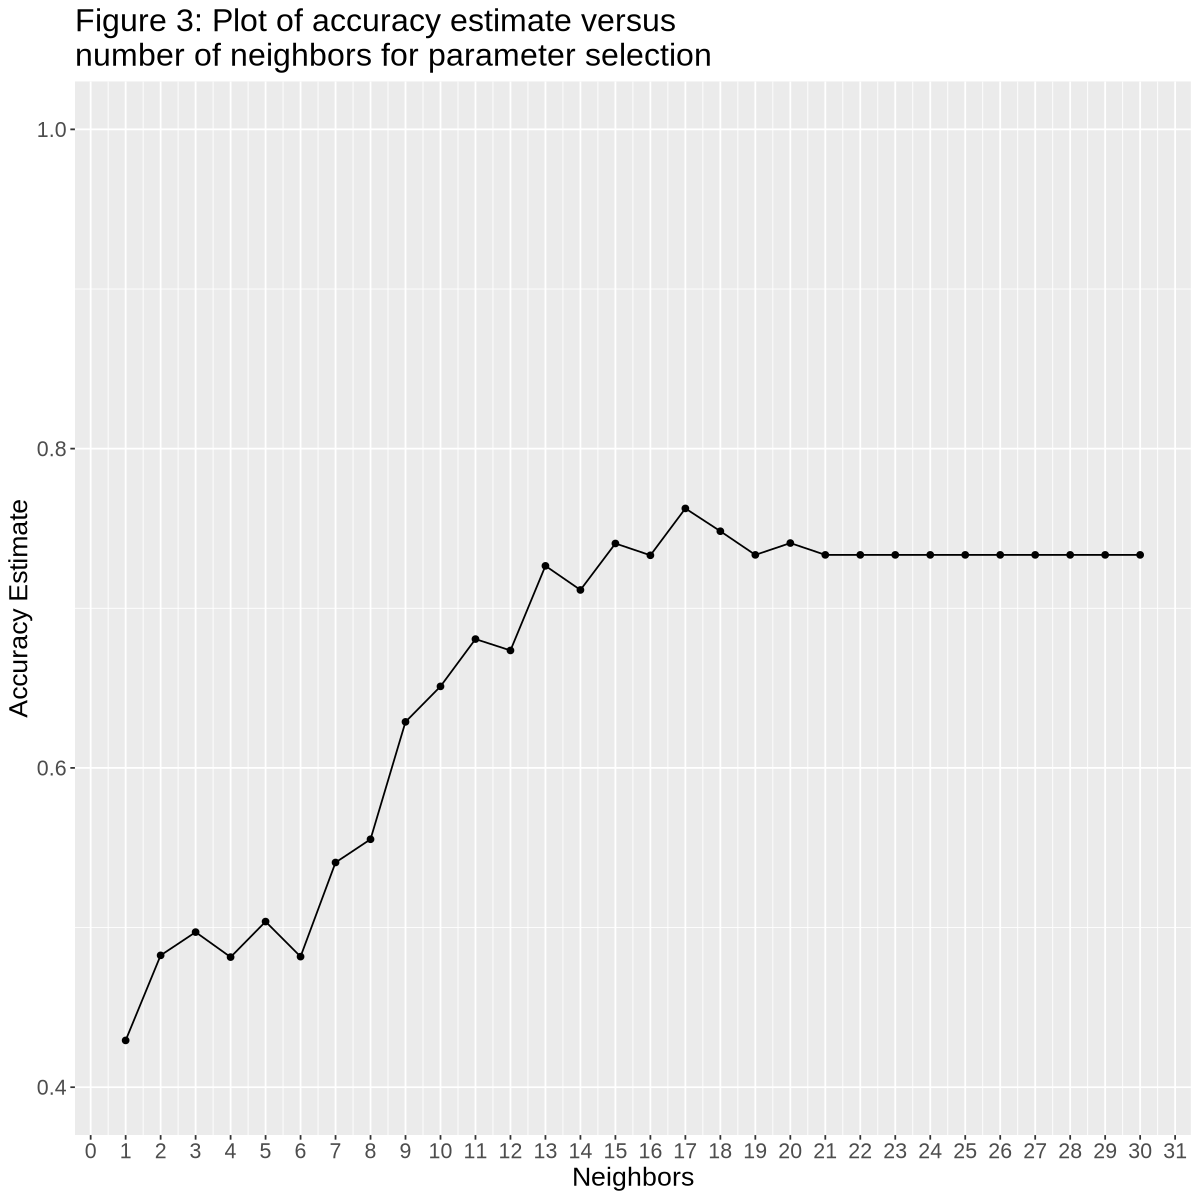

In [25]:
# plot of estimated accuracy versus number of neighbors
figure_3 <- ggplot(knn_results_tune, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", 
            y = "Accuracy Estimate", 
            title = "Figure 3: Plot of accuracy estimate versus\nnumber of neighbors for parameter selection") +
       scale_x_continuous(breaks = seq(0, 40, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0))+
        theme(text = element_text(size = 16))
         
figure_3

After:
- creating a recipe with response variable `subscribe` and predictor variables `Age` and `played_hours` to scale the variables
- specifing k values to test
- creating a model specification
- setting the number of folds
- performing cross validation on the training set, 

we found that the **highest mean, cross-validated accuracy of each fold occurs at k=17 with 76.3% accuracy.**

### We therefore select this K value to build the final model to fit on the training set and evaluate its accuracy on the test set.  

In [26]:
# model specification for final value
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
    set_engine("kknn") |>
    set_mode("classification")

# use the same recipe from the above tuning process to fit model
knn_results_final <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(knn_spec_final) |>
       fit(players_train)

# find accuracy of the model by making it predict the testing set
players_predictions <- predict(knn_results_final, players_test) |>
  bind_cols(players_test)
# players_predictions

players_accuracy <- players_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
players_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


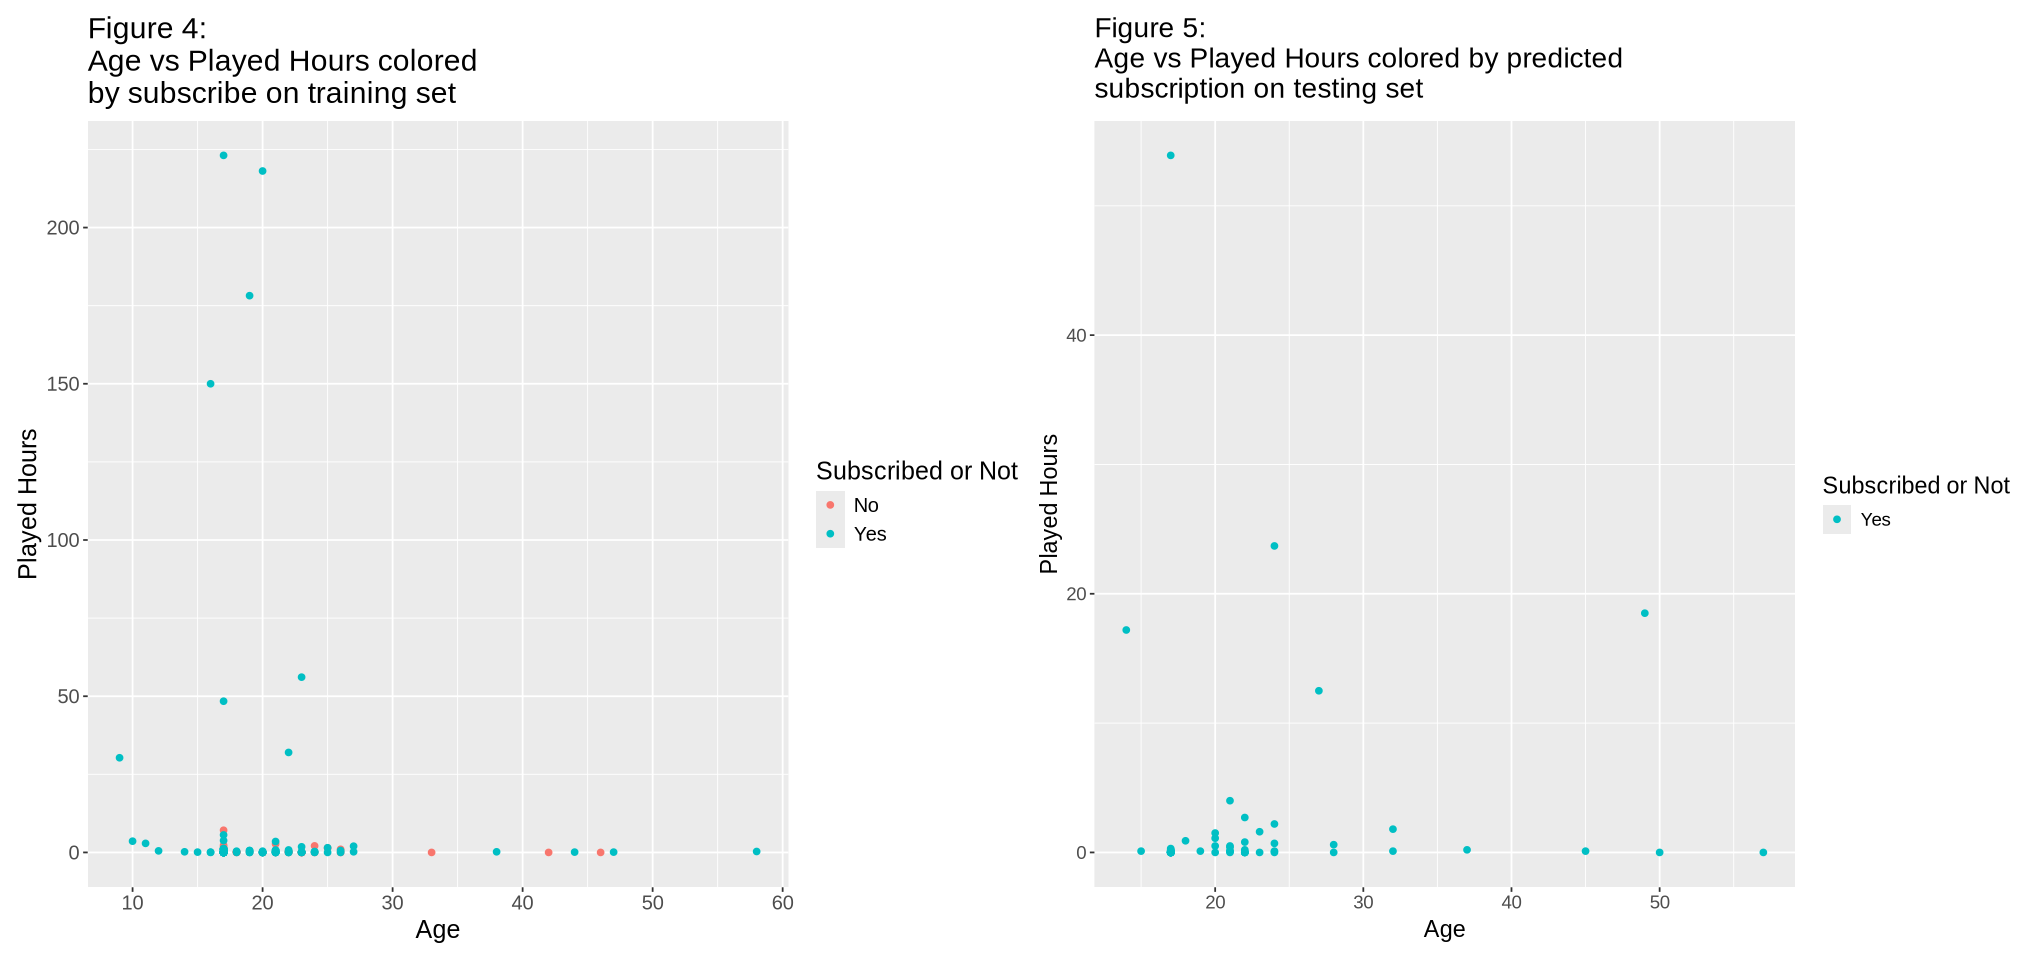

In [31]:
# analysis visualizations
options(repr.plot.height = 8, repr.plot.width = 17)

figure_4 <- ggplot(players_train, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = "Age", 
         y = "Played Hours", 
         title = "Figure 4:\nAge vs Played Hours colored\nby subscribe on training set", 
         color = "Subscribed or Not")  +
    theme(text = element_text(size = 15))

figure_5 <- ggplot(players_predictions, aes(x = Age, y = played_hours, color = .pred_class)) +
    geom_point() +
    scale_color_manual(name = "Subscribed or Not",
                        values = c("Yes" = "#00BFC4")) +
    labs(x = "Age", y = "Played Hours", 
         title = "Figure 5:\nAge vs Played Hours colored by predicted\nsubscription on testing set")+
    theme(text = element_text(size = 14))

combined_4_and_5 <- figure_4 + figure_5
combined_4_and_5

After: 
- setting up a new model specification with `neighbors` = 17
- fitting the model onto the training set
- making the model predict the testing set,

we found that **for using `Age` and `played_hours` to predict `subscribe` on the testing set, the accuracy is around 72.9%.**

From Figure 4 and 5, which are scatter plots of the training set with labels and the testing set with predicted labels laid out [side-by-side](https://patchwork.data-imaginist.com/), we can see that our model predicted all observations on the testing set as "Yes" to being subscribed. 

### 5) Discussion

- Summary of our findings:
  - Through tuning the model, we found the optimal K value with highest accuracy to be 17 neighbors, and the final model predicted a ~73% accuracy on the testing set. 
  - However, although we got a high accuracy from predicting the testing set, the accuracy is misleading; it came from predicting all observations as the majority class. That means using the optimal K value gives meaningless predictions, and using a smaller K value decreases accuracy. Therefore, we can conclude that `Age` and `played_hours` are not reliable predictors for `subscribe` as their relationship with `subscribe` is too weak for the model to learn. They might be predictive when combined with additional predictors, but the two alone do not provide enough information to train the model.
<br>
<br>
- Was this what we expected to find?
    - No, it wasn't. Based on our exploratory data analysis visualizations and common sense, we expected the predictors to be effective at predicting whether a user will subscribe.
    - We hypothesize our findings could also be partly due to the moderate class imbalance we identified at the start, or that the dataset is relatively small for us to both teach and evaluate the model on.
<br>
<br>
- Some future directions we could take to combat this if we want to continue exploring with `Age` and `played_hours`:
  - Change the `weight_func =` argument to something other than "rectangular" (e.g "triangular")
  - Use `step_upsample` when creating the recipe to oversample the minority class
<br>
<br>
- The impact that our findings could have:
    - Someone subscribing indicates higher engagement and a greater likelihood that a player will return to the game. Predicting future subscription statuses can help the research team identify their target audience. Furthermore, our findings can also reveal general characteristics of nonsubscribers to enable strategies to encourage these players to subscribe in the future.
<br>
<br>     
- Future questions:
    - In the future, the research team might want to include data for other variables such as geographical location or lifestyle habits, and combine that information with variables like `Age` and `played_hours` to better predict whether someone has subscribed or not. 